In [1]:
!pip install -q ucimlrepo gurobipy fairlearn xgboost pandas numpy scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.9 MB/s eta 0:00:00


In [2]:
import os
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from fairlearn.reductions import ExponentiatedGradient, GridSearch, FalsePositiveRateParity
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, false_positive_rate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
WLS_ACCESS_ID = "44279020-2707-4d64-b5ef-6424b71b42a2"
WLS_SECRET = "26d7833e-c402-4656-a966-1381a4da6a2d"
LICENSE_ID = 2678226

In [4]:
def check_gurobi_license():
    print("--- Configuring Gurobi License ---")
    try:
        params = {
            "WLSACCESSID": WLS_ACCESS_ID,
            "WLSSECRET": WLS_SECRET,
            "LICENSEID": LICENSE_ID,
            "OutputFlag": 0
        }
        with gp.Env(params=params) as env:
            gp.Model(env=env)
        print("Gurobi license configured successfully!")
        return True
    except gp.GurobiError as e:
        print(f"Gurobi license error: {e.message}")
        return False


## Fair MIP Tree

In [5]:
class FairMIPDecisionTree:
    def __init__(self, max_depth=2, lambda_fairness=1.0, time_limit=180):
        self.max_depth = max_depth
        self.lambda_fairness = lambda_fairness
        self.time_limit = time_limit
        self.model_ = None
        self.tree_ = {}

    def fit(self, X, y, sensitive_features):
        self.features_ = list(X.columns)
        N, P = X.shape
        X_fit = X.reset_index(drop=True); y_fit = y.reset_index(drop=True); s_fit = sensitive_features.reset_index(drop=True)
        group_0_indices = s_fit[s_fit == 0].index; group_1_indices = s_fit[s_fit == 1].index
        N0_neg = len([i for i in group_0_indices if y_fit[i] == 0]) or 1
        N1_neg = len([i for i in group_1_indices if y_fit[i] == 0]) or 1
        branch_nodes = list(range(2**self.max_depth - 1))
        leaf_nodes = list(range(2**self.max_depth - 1, 2**(self.max_depth + 1) - 1))

        wls_params = {"WLSACCESSID": WLS_ACCESS_ID, "WLSSECRET": WLS_SECRET, "LICENSEID": LICENSE_ID, "OutputFlag": 0}
        with gp.Env(params=wls_params) as env:
            m = gp.Model("FairMIP_DT_MIA", env=env)
            m.setParam('TimeLimit', self.time_limit)
            a = m.addVars(branch_nodes, P, vtype=GRB.BINARY, name="a")
            b = m.addVars(branch_nodes, vtype=GRB.CONTINUOUS, name="b")
            c = m.addVars(branch_nodes, vtype=GRB.BINARY, name="c")
            u = m.addVars(leaf_nodes, vtype=GRB.BINARY, name="u")
            z = m.addVars(N, leaf_nodes, vtype=GRB.BINARY, name="z")
            misclassification_loss = m.addVar(vtype=GRB.INTEGER, name="misclass_loss")
            fp_diff_abs = m.addVar(lb=0.0, name="fp_diff_abs")
            M_val = {j: X_fit.iloc[:, j].max() - X_fit.iloc[:, j].min() if not pd.isna(X_fit.iloc[:, j].max()) else 1 for j in range(P)}
            epsilon = 0.001
            m.setObjective(misclassification_loss + self.lambda_fairness * fp_diff_abs, GRB.MINIMIZE)
            m.addConstr(misclassification_loss == gp.quicksum(y_fit[i] * (1 - gp.quicksum(u[l] * z[i,l] for l in leaf_nodes)) + (1-y_fit[i]) * gp.quicksum(u[l] * z[i,l] for l in leaf_nodes) for i in range(N)))
            m.addConstrs((z.sum(i, '*') == 1 for i in range(N)))
            m.addConstrs((a.sum(t, '*') <= 1 for t in branch_nodes))
            for i in range(N):
                for l in leaf_nodes:
                    path_to_leaf = self._get_path(l)
                    for t, direction in path_to_leaf:
                        for j in range(P):
                            if not pd.isna(X_fit.iloc[i, j]):
                                if direction == 0:
                                    m.addConstr(b[t] >= X_fit.iloc[i,j] - M_val[j]*(1-z[i,l]) - M_val[j]*(1-a[t,j]))
                                else:
                                    m.addConstr(b[t] <= X_fit.iloc[i,j] - epsilon + M_val[j]*(1-z[i,l]) + M_val[j]*(1-a[t,j]))
                            else:
                                m.addConstr((1-direction) * a[t,j] + c[t] * a[t,j] <= 1 + (1-z[i,l]))
                                m.addConstr(direction * a[t,j] + (1-c[t]) * a[t,j] <= 1 + (1-z[i,l]))
            fpr_g0_numerator = gp.quicksum(u[l] * z[i, l] for l in leaf_nodes for i in group_0_indices if y_fit[i] == 0)
            fpr_g1_numerator = gp.quicksum(u[l] * z[i, l] for l in leaf_nodes for i in group_1_indices if y_fit[i] == 0)
            m.addConstr(fp_diff_abs * N0_neg * N1_neg >= N1_neg * fpr_g0_numerator - N0_neg * fpr_g1_numerator)
            m.addConstr(fp_diff_abs * N0_neg * N1_neg >= N0_neg * fpr_g1_numerator - N1_neg * fpr_g0_numerator)
            print("Starting MIP optimization...")
            m.optimize()
            self.model_ = m
            if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT] and m.solCount > 0:
                print("Optimization finished. Extracting tree structure...")
                self.tree_['splits'] = {t: (self.features_[j], b[t].X) for t in branch_nodes for j in range(P) if a[t, j].X > 0.5}
                self.tree_['mia_direction'] = {t: ('left' if c[t].X < 0.5 else 'right') for t in branch_nodes if t in self.tree_['splits']}
                self.tree_['leaf_predictions'] = {l: int(round(u[l].X)) for l in leaf_nodes}

    def predict(self, X):
        if 'splits' not in self.tree_: raise ValueError("Model not fitted or no solution found.")
        X_pred = X.reset_index(drop=True)
        predictions = []
        for i in range(X_pred.shape[0]):
            node = 0
            current_depth = 0
            while current_depth < self.max_depth:
                if node not in self.tree_['splits']: break
                feature_name, threshold = self.tree_['splits'][node]
                feature_idx = self.features_.index(feature_name)
                value = X_pred.iloc[i, feature_idx]
                if pd.isna(value):
                    direction = self.tree_['mia_direction'][node]
                    node = 2 * node + 1 if direction == 'left' else 2 * node + 2
                else:
                    node = 2 * node + 1 if value <= threshold else 2 * node + 2
                current_depth += 1
            predictions.append(self.tree_['leaf_predictions'].get(node, 0))
        return np.array(predictions)

    def _get_metrics(self, X, y, sensitive_features):
        y_pred = self.predict(X)
        return get_metrics(y, y_pred, sensitive_features)

    def _get_path(self, leaf_idx):
        path = []; curr = leaf_idx
        while curr > 0:
            parent = (curr-1)//2
            direction = 0 if curr == 2*parent+1 else 1
            path.append((parent, direction)); curr = parent
        return path[::-1]


In [6]:

def introduce_missingness(df, sensitive_col_series, features_to_miss, probs):
    df_missing = df.copy()
    s = sensitive_col_series
    for feature, (prob_g0, prob_g1) in probs.items():
        if feature not in df_missing.columns: continue
        idx_g0 = s[s == 0].index
        mask_g0 = np.random.rand(len(idx_g0)) < prob_g0
        df_missing.loc[idx_g0[mask_g0], feature] = np.nan

        idx_g1 = s[s == 1].index
        mask_g1 = np.random.rand(len(idx_g1)) < prob_g1
        df_missing.loc[idx_g1[mask_g1], feature] = np.nan
    return df_missing

def get_metrics(y_true, y_pred, sensitive_features):
    mf = MetricFrame(metrics={'accuracy': accuracy_score, 'fpr': false_positive_rate},
                       y_true=y_true, y_pred=y_pred,
                       sensitive_features=sensitive_features)
    return {'accuracy': mf.overall['accuracy'], 'fpr_difference': mf.difference(method='between_groups')['fpr']}


--- Configuring Gurobi License ---
Gurobi license configured successfully!

 Loading and Preprocessing Adult Dataset 
Unified training size for ALL models: 10000
Test set size: 2000
Missing values introduced.

Running Baseline Models
Running Agarwal (ExpGrad)
Running Zafar (GridSearch)
Running Hardt (Postprocessing)

Running Fair MIP Optimal Tree with MIA
Starting MIP optimization...
Optimization finished. Extracting tree structure...
-> MIP Tree Results: Acc=0.8395, FPR_Diff=0.0000

Tree Structure: {'splits': {}, 'mia_direction': {}, 'leaf_predictions': {3: 1, 4: 0, 5: 0, 6: 0}}

Generating Plot


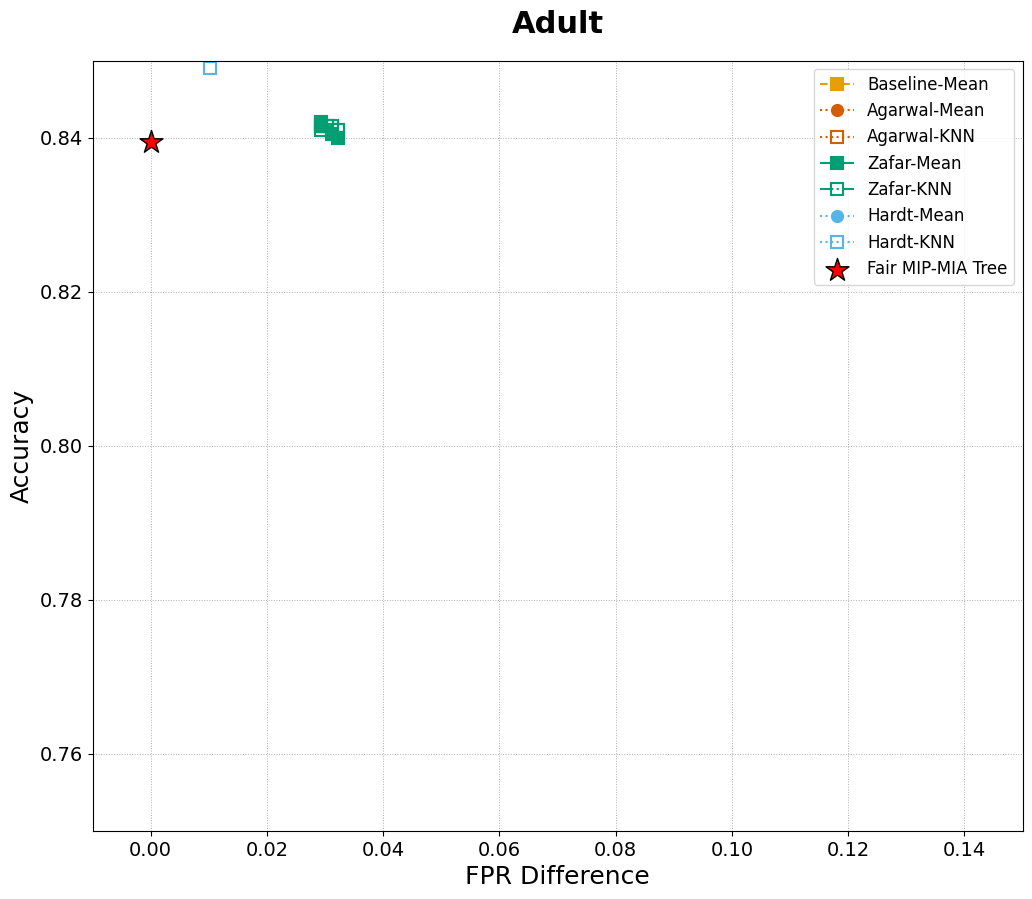


 Loading and Preprocessing Bank Marketing Dataset 
Unified training size for ALL models: 10000
Test set size: 2000
Missing values introduced.

Running Baseline Models
Running Agarwal (ExpGrad)
Running Zafar (GridSearch)
Running Hardt (Postprocessing)

Running Fair MIP Optimal Tree with MIA
Starting MIP optimization...
Optimization finished. Extracting tree structure...
-> MIP Tree Results: Acc=0.8830, FPR_Diff=0.0000

Tree Structure: {'splits': {}, 'mia_direction': {}, 'leaf_predictions': {3: 1, 4: 0, 5: 0, 6: 0}}

Generating Plot


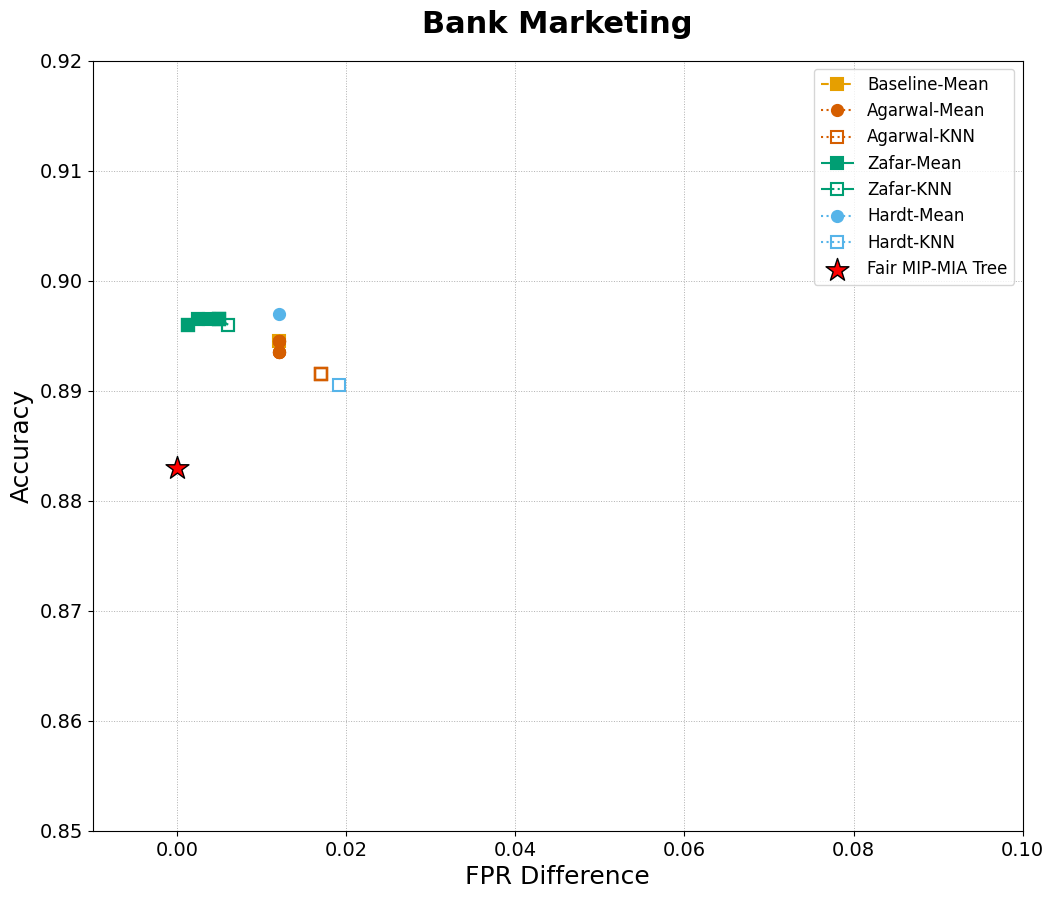

In [7]:

def run_experiment(dataset_name, uciml_id, target_col, target_positive_val, s_col, s_col_binner,
                   features_to_miss, missing_probs, plot_ylim, plot_xlim):

    # Data Loading and Preprocessing
    print(f"\n Loading and Preprocessing {dataset_name} Dataset ")
    try:
        from ucimlrepo import fetch_ucirepo
        data_raw = fetch_ucirepo(id=uciml_id)
        X_raw = data_raw.data.features.copy()
        y_raw = (data_raw.data.targets[target_col] == target_positive_val).astype(int)
    except Exception as e:
        print(f"Could not fetch from ucimlrepo. Error: {e}")
        return

    X_raw.replace('unknown', np.nan, inplace=True)
    X_numeric = X_raw.copy()
    for col in X_numeric.select_dtypes(include=['object']).columns:
        X_numeric[col] = pd.factorize(X_numeric[col])[0]
    sensitive_attribute_series = s_col_binner(X_raw)
    stratify_on = y_raw.astype(str) + sensitive_attribute_series.astype(str)

    #Data Splitting

    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        X_numeric, y_raw, sensitive_attribute_series, train_size=10000, test_size=2000,
        random_state=42, stratify=stratify_on
    )

    print(f"Unified training size for ALL models: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    X_train_miss = introduce_missingness(X_train, s_train, features_to_miss, missing_probs)
    X_test_miss = introduce_missingness(X_test, s_test, features_to_miss, missing_probs)
    print("Missing values introduced.\n")

    #Experiment Execution
    results_dict = {}
    numerical_features = [c for c in X_numeric.columns if c != s_col]
    preprocessors = {
        'Mean': ColumnTransformer([('impute_scale', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features)], remainder='passthrough'),
        'KNN': ColumnTransformer([('impute_scale', Pipeline([('imputer', KNNImputer(n_neighbors=5)), ('scaler', StandardScaler())]), numerical_features)], remainder='passthrough')
    }
    lambda_sweep = np.linspace(0.002, 0.1, 8)
    grid_size_sweep = np.linspace(0.001, 0.08, 8)

    #Run Benchmark Models on the unified training set
    print("Running Baseline Models")
    for impute_name, preprocessor in preprocessors.items():
        X_train_p = preprocessor.fit_transform(X_train_miss); X_test_p = preprocessor.transform(X_test_miss)
        model = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train_p, y_train)
        results_dict[f"Baseline-{impute_name}"] = [get_metrics(y_test, model.predict(X_test_p), s_test)]

    print("Running Agarwal (ExpGrad)")
    for impute_name, preprocessor in preprocessors.items():
        curve = []; X_train_p = preprocessor.fit_transform(X_train_miss); X_test_p = preprocessor.transform(X_test_miss)
        for eps in lambda_sweep:
            model = ExponentiatedGradient(DecisionTreeClassifier(max_depth=5), constraints=FalsePositiveRateParity(), eps=eps)
            model.fit(X_train_p, y_train, sensitive_features=s_train); y_pred = model.predict(X_test_p)
            curve.append(get_metrics(y_test, y_pred, s_test))
        results_dict[f"Agarwal-{impute_name}"] = curve

    print("Running Zafar (GridSearch)")
    for impute_name, preprocessor in preprocessors.items():
        curve = []; X_train_p = preprocessor.fit_transform(X_train_miss); X_test_p = preprocessor.transform(X_test_miss)
        for c in grid_size_sweep:
            model = GridSearch(LogisticRegression(solver='liblinear'), constraints=FalsePositiveRateParity(), grid_size=40, grid_limit=c)
            model.fit(X_train_p, y_train, sensitive_features=s_train); y_pred = model.predict(X_test_p)
            curve.append(get_metrics(y_test, y_pred, s_test))
        results_dict[f"Zafar-{impute_name}"] = curve

    print("Running Hardt (Postprocessing)")
    for impute_name, preprocessor in preprocessors.items():
        X_train_p = preprocessor.fit_transform(X_train_miss); X_test_p = preprocessor.transform(X_test_miss)
        base_model = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train_p, y_train)
        model = ThresholdOptimizer(estimator=base_model, constraints="false_positive_rate_parity", objective="accuracy_score", prefit=True)
        model.fit(X_train_p, y_train, sensitive_features=s_train)
        y_pred = model.predict(X_test_p, sensitive_features=s_test)
        results_dict[f"Hardt-{impute_name}"] = [get_metrics(y_test, y_pred, s_test)]

    #Run Fair MIP Tree Model on the unified training set
    print("\nRunning Fair MIP Optimal Tree with MIA")
    fair_mip_tree = FairMIPDecisionTree(max_depth=2, lambda_fairness=0.5, time_limit=300)
    try:
        fair_mip_tree.fit(X_train_miss, y_train, s_train)
        if fair_mip_tree.model_ and fair_mip_tree.model_.solCount > 0:
            metrics = fair_mip_tree._get_metrics(X_test_miss, y_test, s_test)
            results_dict["Fair MIP-MIA Tree"] = [metrics]
            print(f"-> MIP Tree Results: Acc={metrics['accuracy']:.4f}, FPR_Diff={abs(metrics['fpr_difference']):.4f}")
            print("\nTree Structure:", fair_mip_tree.tree_)
        else:
            print("\nMIP solver did not find a feasible solution within the time limit.")
    except Exception as e:
        print(f"\nAn error occurred during MIP fitting: {e}")

    #Results Visualization
    print("\nGenerating Plot")
    fig, ax = plt.subplots(figsize=(12, 10))
    styles = {
        'Fair MIP-MIA Tree': {'color': 'red', 'marker': '*', 'linestyle': 'none', 'label': 'Fair MIP-MIA Tree', 's': 300, 'edgecolor':'black'},
        'Baseline-Mean': {'color': '#E69F00', 'marker': 's', 'linestyle': '--', 'label': 'Baseline-Mean', 'mfc': '#E69F00'},
        'Agarwal-Mean':  {'color': '#D55E00', 'marker': 'o', 'linestyle': ':', 'label': 'Agarwal-Mean', 'mfc': '#D55E00'},
        'Agarwal-KNN':   {'color': '#D55E00', 'marker': 's', 'linestyle': ':', 'label': 'Agarwal-KNN', 'mfc':'none'},
        'Zafar-Mean':    {'color': '#009E73', 'marker': 's', 'linestyle': '-.', 'label': 'Zafar-Mean', 'mfc': '#009E73'},
        'Zafar-KNN':     {'color': '#009E73', 'marker': 's', 'linestyle': '-.', 'label': 'Zafar-KNN', 'mfc':'none'},
        'Hardt-Mean':    {'color': '#56B4E9', 'marker': 'o', 'linestyle': ':', 'label': 'Hardt-Mean', 'mfc': '#56B4E9'},
        'Hardt-KNN':     {'color': '#56B4E9', 'marker': 's', 'linestyle': ':', 'label': 'Hardt-KNN', 'mfc':'none'},
    }
    for name, points in results_dict.items():
        if name == 'Baseline-KNN': continue
        df = pd.DataFrame(points)
        if df.empty: continue
        df['fpr_difference_abs'] = df['fpr_difference'].abs()
        style = styles.get(name)
        if not style: continue

        if name == "Fair MIP-MIA Tree":
             ax.scatter(df['fpr_difference_abs'], df['accuracy'],
                        marker=style['marker'], color=style['color'], s=style['s'],
                        edgecolor=style['edgecolor'], label=style['label'], zorder=10)
        else:
            df_sorted = df.sort_values(by='fpr_difference_abs')
            ax.plot(df_sorted['fpr_difference_abs'], df_sorted['accuracy'],
                    marker=style['marker'], color=style['color'], linestyle=style['linestyle'],
                    mfc=style.get('mfc'), mec=style['color'], mew=1.5, ms=8, label=style['label'])

    ax.set_xlabel("FPR Difference", fontsize=18)
    ax.set_ylabel("Accuracy", fontsize=18)
    ax.set_title(dataset_name, fontsize=22, weight='bold', pad=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, which='both', linestyle=':', linewidth=0.7)
    ax.set_ylim(plot_ylim)
    ax.set_xlim(plot_xlim)
    ax.legend(fontsize=12)
    plt.show()

if __name__ == "__main__":
    if check_gurobi_license():
        # Adult Dataset
        run_experiment(
            dataset_name="Adult",
            uciml_id=2,
            target_col='income',
            target_positive_val='>50K',
            s_col='sex',
            s_col_binner=lambda df: (df['sex'] == 'Male').astype(int),
            features_to_miss=['age', 'hours-per-week', 'capital-gain'],
            missing_probs={'age': (0.2, 0.1), 'hours-per-week': (0.1, 0.2), 'capital-gain': (0.15, 0.15)},
            plot_ylim=(0.75, 0.85),
            plot_xlim=(-0.01, 0.15)
        )

        #Bank Marketing Dataset
        run_experiment(
            dataset_name="Bank Marketing",
            uciml_id=222,
            target_col='y',
            target_positive_val='yes',
            s_col='age',
            s_col_binner=lambda df: (df['age'] > 40).astype(int),
            features_to_miss=['job', 'education', 'duration'],
            missing_probs={'job': (0.1, 0.3), 'education': (0.3, 0.1), 'duration': (0.05, 0.05)},
            plot_ylim=(0.85, 0.92),
            plot_xlim=(-0.01, 0.1)
        )

## Future Implementation

In [8]:
class FairMIPDecisionTree:
    def __init__(self, max_depth=5, lambda_fairness=0, time_limit=300, fairness_metric='fprp'):
        self.max_depth, self.lambda_fairness, self.time_limit, self.fairness_metric = max_depth, lambda_fairness, time_limit, fairness_metric
        self.model_, self.tree_, self.objective_value_ = None, {}, float('inf')
        self.majority_class_ = 0 # Default majority class

    def fit(self, X, y, sensitive_features):
        self.features_ = list(X.columns); N, P = X.shape
        X_fit, y_fit, s_fit = (d.reset_index(drop=True) for d in [X, y, sensitive_features])

        # --- FIX 1: Store the majority class of the training data ---
        self.majority_class_ = y_fit.mode()[0]

        g0_idx, g1_idx = s_fit[s_fit == 0].index, s_fit[s_fit == 1].index
        branch_nodes, leaf_nodes = list(range(2**self.max_depth - 1)), list(range(2**self.max_depth - 1, 2**(self.max_depth + 1) - 1))

        wls_params = {"WLSACCESSID": WLS_ACCESS_ID, "WLSSECRET": WLS_SECRET, "LICENSEID": LICENSE_ID, "OutputFlag": 0}
        with gp.Env(params=wls_params) as env:
            m = gp.Model("FairMIP_DT_MIA", env=env); m.setParam('TimeLimit', self.time_limit)
            a, b = m.addVars(branch_nodes, P, vtype=GRB.BINARY), m.addVars(branch_nodes, vtype=GRB.CONTINUOUS)
            c, u, z = m.addVars(branch_nodes, vtype=GRB.BINARY), m.addVars(leaf_nodes, vtype=GRB.BINARY), m.addVars(N, leaf_nodes, vtype=GRB.BINARY)
            loss, fair_diff = m.addVar(vtype=GRB.INTEGER), m.addVar(lb=0.0)
            M_val = {j: X_fit.iloc[:, j].max() - X_fit.iloc[:, j].min() if not pd.isna(X_fit.iloc[:, j].max()) else 1 for j in range(P)}

            m.setObjective(loss + self.lambda_fairness * fair_diff, GRB.MINIMIZE)
            m.addConstr(loss == gp.quicksum((y_fit[i] * (1 - gp.quicksum(u[l] * z[i,l] for l in leaf_nodes)) + (1-y_fit[i]) * gp.quicksum(u[l] * z[i,l] for l in leaf_nodes)) for i in range(N)))
            m.addConstrs((z.sum(i, '*') == 1 for i in range(N))); m.addConstrs((a.sum(t, '*') <= 1 for t in branch_nodes))

            for i in range(N):
                for l in leaf_nodes:
                    for t, direction in self._get_path(l):
                        for j in range(P):
                            if not pd.isna(X_fit.iloc[i, j]):
                                if direction == 0: m.addConstr(b[t] >= X_fit.iloc[i,j] - M_val[j]*(1-z[i,l]) - M_val[j]*(1-a[t,j]))
                                else: m.addConstr(b[t] <= X_fit.iloc[i,j] - 0.001 + M_val[j]*(1-z[i,l]) + M_val[j]*(1-a[t,j]))
                            else:
                                m.addConstr((1-direction)*a[t,j] + c[t]*a[t,j] <= 1 + (1-z[i,l])); m.addConstr(direction*a[t,j] + (1-c[t])*a[t,j] <= 1 + (1-z[i,l]))

            if self.fairness_metric == 'fprp':
                N0_neg, N1_neg = len([i for i in g0_idx if y_fit[i] == 0]) or 1, len([i for i in g1_idx if y_fit[i] == 0]) or 1
                g0_num, g1_num = gp.quicksum(u[l]*z[i,l] for l in leaf_nodes for i in g0_idx if y_fit[i]==0), gp.quicksum(u[l]*z[i,l] for l in leaf_nodes for i in g1_idx if y_fit[i]==0)
                m.addConstr(fair_diff * N0_neg * N1_neg >= N1_neg * g0_num - N0_neg * g1_num); m.addConstr(fair_diff * N0_neg * N1_neg >= N0_neg * g1_num - N1_neg * g0_num)
            elif self.fairness_metric == 'dp':
                N0, N1 = len(g0_idx) or 1, len(g1_idx) or 1
                g0_num, g1_num = gp.quicksum(u[l]*z[i,l] for l in leaf_nodes for i in g0_idx), gp.quicksum(u[l]*z[i,l] for l in leaf_nodes for i in g1_idx)
                m.addConstr(fair_diff * N0 * N1 >= N1 * g0_num - N0 * g1_num); m.addConstr(fair_diff * N0 * N1 >= N0 * g1_num - N1 * g0_num)

            print(f"Starting MIP optimization (Metric: {self.fairness_metric.upper()})..."); m.optimize(); self.model_ = m
            if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT] and m.solCount > 0:
                print("Optimization finished."); self.objective_value_ = m.objVal
                self.tree_['splits'] = {t: (self.features_[j], b[t].X) for t in branch_nodes for j in range(P) if a[t, j].X > 0.5}
                self.tree_['mia_direction'] = {t: ('left' if c[t].X < 0.5 else 'right') for t in branch_nodes if t in self.tree_['splits']}
                self.tree_['leaf_predictions'] = {l: int(round(u[l].X)) for l in leaf_nodes}

    def predict(self, X):
        # --- FIX 2: Use the stored majority class for trivial trees ---
        if not self.tree_ or not self.tree_.get('splits'):
            return np.full(len(X), self.majority_class_, dtype=int)

        X_pred = X.reset_index(drop=True); predictions = []
        for i in range(X_pred.shape[0]):
            node, depth = 0, 0
            while depth < self.max_depth:
                if node not in self.tree_['splits']: break
                feature_name, threshold = self.tree_['splits'][node]; feature_idx = self.features_.index(feature_name)
                value = X_pred.iloc[i, feature_idx]
                if pd.isna(value): direction = self.tree_['mia_direction'][node]; node = 2*node+1 if direction == 'left' else 2*node+2
                else: node = 2*node+1 if value <= threshold else 2*node+2
                depth += 1
            predictions.append(self.tree_['leaf_predictions'].get(node, self.majority_class_))
        return np.array(predictions)

    def _get_path(self, l_idx):
        p=[]; c=l_idx
        while c>0: p_node=(c-1)//2; p.append((p_node, 0 if c==2*p_node+1 else 1)); c=p_node
        return p[::-1]

class FairMIPEnsemble:
    def __init__(self, n_estimators=3, voting='majority', max_depth=5, lambda_fairness=0, time_limit=300):
        self.n_estimators, self.voting, self.max_depth, self.lambda_fairness, self.time_limit = n_estimators, voting, max_depth, lambda_fairness, time_limit
        self.estimators_ = []

    def fit(self, X, y, s):
        self.estimators_ = []
        for i in range(self.n_estimators):
            print(f"\n--- Training estimator {i+1}/{self.n_estimators} ---")
            X_b, y_b, s_b = resample(X, y, s, random_state=i)
            est = FairMIPDecisionTree(max_depth=self.max_depth, lambda_fairness=self.lambda_fairness, time_limit=self.time_limit)
            est.fit(X_b, y_b, s_b)
            if est.model_.solCount > 0: self.estimators_.append(est)
        return self

    def predict(self, X):
        if not self.estimators_: raise ValueError("Ensemble has no fitted estimators.")
        preds = np.array([est.predict(X) for est in self.estimators_]).T
        if self.voting == 'majority': return mode(preds, axis=1, keepdims=False)[0]
        elif self.voting == 'weighted':
            w = np.array([1 / (est.objective_value_ + 1e-6) for est in self.estimators_])
            return np.rint(np.average(preds, axis=1, weights=w)).astype(int)

def hybrid_impute(df, col):
    df_h = df.copy(); df_h[col] = SimpleImputer(strategy='mean').fit_transform(df_h[[col]]); return df_h

def get_metrics(y_true, y_pred, s):
    mf = MetricFrame(metrics={'accuracy': accuracy_score, 'fpr': false_positive_rate, 'selection_rate': lambda y_t, y_p: np.mean(y_p)},
                       y_true=y_true, y_pred=y_pred, sensitive_features=s)
    return {'accuracy': mf.overall['accuracy'], 'fpr_difference': mf.difference()['fpr'], 'dp_difference': mf.difference()['selection_rate']}



In [ ]:

def run_extended_experiments(dataset_name="Adult", uciml_id=2, time_limit=300):

    from ucimlrepo import fetch_ucirepo
    data_raw=fetch_ucirepo(id=uciml_id); X_raw=data_raw.data.features.copy()
    y_raw=(data_raw.data.targets['income']=='>50K').astype(int); X_raw.replace('unknown',np.nan,inplace=True)
    X_numeric=X_raw.copy()
    for col in X_numeric.select_dtypes(include=['object']).columns: X_numeric[col]=pd.factorize(X_numeric[col])[0]
    s_series = (X_raw['sex'] == 'Male').astype(int)
    stratify_on = y_raw.astype(str) + s_series.astype(str)

    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
        X_numeric, y_raw, s_series, train_size=400, test_size=1000, random_state=42, stratify=stratify_on)

    features_to_miss = {'age': (0.2, 0.1), 'hours-per-week': (0.1, 0.2), 'capital-gain': (0.3, 0.4)}
    X_train_miss = introduce_missingness(X_train, s_train, features_to_miss.keys(), {k:v for k,v in features_to_miss.items()})
    X_test_miss = introduce_missingness(X_test, s_test, features_to_miss.keys(), {k:v for k,v in features_to_miss.items()})
    print(f"Unified training size: {len(X_train)}, Test size: {len(X_test)}\n")

    results = {}

    print("\nBaseline Fair MIP Tree (FPRP) with Lambda Sweep")
    lambda_sweep = [0.1, 0.5, 2.0, 10.0]
    baseline_curve = []
    for lam in lambda_sweep:
        print(f"  Training with lambda = {lam}")
        tree = FairMIPDecisionTree(max_depth=5, lambda_fairness=lam, time_limit=time_limit, fairness_metric='fprp')
        tree.fit(X_train_miss, y_train, s_train)
        if tree.tree_ and tree.tree_['splits']:
            print(f"    -> Found non-trivial tree: {tree.tree_['splits']}")
        else:
            print("    -> Found a trivial (no-split) tree.")
        baseline_curve.append(get_metrics(y_test, tree.predict(X_test_miss), s_test))
    results['Baseline MIP Curve (FPRP)'] = baseline_curve

    # 2. Experiment 1: Demographic Parity Metric (single point)
    print("\nRunning 2: MIP with Demographic Parity")
    dp_tree = FairMIPDecisionTree(max_depth=5, lambda_fairness=0, time_limit=time_limit, fairness_metric='dp')
    dp_tree.fit(X_train_miss, y_train, s_train)
    results['MIP (DP)'] = [get_metrics(y_test, dp_tree.predict(X_test_miss), s_test)]

    # 3. Experiment 2: Hybrid Imputation + MIA (single point)
    print("\nRunning 3: MIP with Hybrid Imputation")
    X_train_hybrid, X_test_hybrid = hybrid_impute(X_train_miss, 'capital-gain'), hybrid_impute(X_test_miss, 'capital-gain')
    hybrid_tree = FairMIPDecisionTree(max_depth=5, lambda_fairness=0.5, time_limit=time_limit, fairness_metric='fprp')
    hybrid_tree.fit(X_train_hybrid, y_train, s_train)
    results['MIP (Hybrid Impute)'] = [get_metrics(y_test, hybrid_tree.predict(X_test_hybrid), s_test)]

    # 4. Experiment 3: Ensemble Methods (single points)
    print("\nRunning 4a: Ensemble with Majority Voting")
    ensemble_maj = FairMIPEnsemble(n_estimators=3, voting='majority', time_limit=time_limit, max_depth=5)
    ensemble_maj.fit(X_train_miss, y_train, s_train)
    results['Ensemble (Majority)'] = [get_metrics(y_test, ensemble_maj.predict(X_test_miss), s_test)]

    print("\nRunning 4b: Ensemble with Weighted Voting")
    ensemble_wgt = FairMIPEnsemble(n_estimators=3, voting='weighted', time_limit=time_limit, max_depth=5)
    ensemble_wgt.fit(X_train_miss, y_train, s_train)
    results['Ensemble (Weighted)'] = [get_metrics(y_test, ensemble_wgt.predict(X_test_miss), s_test)]


    results_df = {k: pd.DataFrame(v) for k, v in results.items() if v}
    print("\n\nFinal Results"); [print(f"\n{k}:\n{v}") for k, v in results_df.items()]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
    markers = {'Baseline MIP Curve (FPRP)':'o', 'MIP (DP)':'s', 'MIP (Hybrid Impute)':'D', 'Ensemble (Majority)':'P', 'Ensemble (Weighted)':'*'}
    colors = {'Baseline MIP Curve (FPRP)':'#E69F00', 'MIP (DP)':'#0072B2', 'MIP (Hybrid Impute)':'#009E73', 'Ensemble (Majority)':'#D55E00', 'Ensemble (Weighted)':'#CC79A7'}

    for name, df in results_df.items():
        if df.empty: continue
        df['fpr_difference_abs'] = df['fpr_difference'].abs(); df['dp_difference_abs'] = df['dp_difference'].abs()

        is_curve = 'Curve' in name
        plot_marker = f"-{markers[name]}" if is_curve else markers[name]

        # Plot 1: Accuracy vs FPR Difference
        df1 = df.sort_values('fpr_difference_abs')
        ax1.plot(df1['fpr_difference_abs'], df1['accuracy'], plot_marker, label=name, color=colors[name], ms=10, mec='black' if not is_curve else None)

        # Plot 2: Accuracy vs DP Difference
        df2 = df.sort_values('dp_difference_abs')
        ax2.plot(df2['dp_difference_abs'], df2['accuracy'], plot_marker, label=name, color=colors[name], ms=10, mec='black' if not is_curve else None)

    ax1.set_title("Trade-off vs. False Positive Rate Parity", fontsize=16); ax1.set_xlabel("FPR Difference (Abs)", fontsize=14)
    ax1.set_ylabel("Accuracy", fontsize=14); ax1.grid(True, linestyle=':'); ax1.legend()
    ax2.set_title("Trade-off vs. Demographic Parity", fontsize=16); ax2.set_xlabel("DP Difference (Abs)", fontsize=14)
    ax2.set_ylabel("Accuracy", fontsize=14); ax2.grid(True, linestyle=':'); ax2.legend()
    fig.suptitle(f'Analysis of Fair MIP Tree Extensions (max_depth=1) on {dataset_name}', fontsize=22, weight='bold'); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()



if __name__ == "__main__":
    if check_gurobi_license():
        run_extended_experiments(time_limit=300)